In [46]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
    	self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
	""" Class for making a forward pass, and getting:
	1. The network output.
	2. Activations from intermeddiate targetted layers.
	3. Gradients from intermeddiate targetted layers. """
	def __init__(self, model, target_layers):
		self.model = model
		self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

	def get_gradients(self):
		return self.feature_extractor.gradients

	def __call__(self, x):
		target_activations, output  = self.feature_extractor(x)
		output = output.view(output.size(0), -1)
		output = self.model.classifier(output)
		return target_activations, output

def preprocess_image(img):
	means=[0.485, 0.456, 0.406]
	stds=[0.229, 0.224, 0.225]

	preprocessed_img = img.copy()[: , :, ::-1]
	for i in range(3):
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
	preprocessed_img = \
		np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
	preprocessed_img = torch.from_numpy(preprocessed_img)
	preprocessed_img.unsqueeze_(0)
	input = Variable(preprocessed_img, requires_grad = True)
	return input

def show_cam_on_image(img, mask):
	heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
	heatmap = np.float32(heatmap) / 255
	cam = heatmap + np.float32(img)
	cam = cam / np.max(cam)
    #return cam
	cv2.imwrite("cam.jpg", np.uint8(255 * cam))

class GradCam:
	def __init__(self, model, target_layer_names, use_cuda):
		self.model = model
		self.model.eval()
		self.cuda = use_cuda
		if self.cuda:
			self.model = model.cuda()

		self.extractor = ModelOutputs(self.model, target_layer_names)

	def forward(self, input):
		return self.model(input) 

	def __call__(self, input, index = None):
		if self.cuda:
			features, output = self.extractor(input.cuda())
		else:
			features, output = self.extractor(input)

		if index == None:
			index = np.argmax(output.cpu().data.numpy())

		one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
		one_hot[0][index] = 1
		one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
		if self.cuda:
			one_hot = torch.sum(one_hot.cuda() * output)
		else:
			one_hot = torch.sum(one_hot * output)

		self.model.features.zero_grad()
		self.model.classifier.zero_grad()
		one_hot.backward(retain_graph=True)

		grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

		target = features[-1]
		target = target.cpu().data.numpy()[0, :]

		weights = np.mean(grads_val, axis = (2, 3))[0, :]
		cam = np.zeros(target.shape[1 : ], dtype = np.float32)

		for i, w in enumerate(weights):
			cam += w * target[i, :, :]

		cam = np.maximum(cam, 0)
		cam = cv2.resize(cam, (224, 224))
		cam = cam - np.min(cam)
		cam = cam / np.max(cam)
		return cam

class GuidedBackpropReLU(Function):

    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input), torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output, positive_mask_1), positive_mask_2)

        return grad_input

class GuidedBackpropReLUModel:
	def __init__(self, model, use_cuda):
		self.model = model
		self.model.eval()
		self.cuda = use_cuda
		if self.cuda:
			self.model = model.cuda()

		# replace ReLU with GuidedBackpropReLU
		for idx, module in self.model.features._modules.items():
			if module.__class__.__name__ == 'ReLU':
				self.model.features._modules[idx] = GuidedBackpropReLU()

	def forward(self, input):
		return self.model(input)

	def __call__(self, input, index = None):
		if self.cuda:
			output = self.forward(input.cuda())
		else:
			output = self.forward(input)

		if index == None:
			index = np.argmax(output.cpu().data.numpy())

		one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
		one_hot[0][index] = 1
		one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
		if self.cuda:
			one_hot = torch.sum(one_hot.cuda() * output)
		else:
			one_hot = torch.sum(one_hot * output)

		# self.model.features.zero_grad()
		# self.model.classifier.zero_grad()
		one_hot.backward(retain_graph=True)

		output = input.grad.cpu().data.numpy()
		output = output[0,:,:,:]

		return output

def get_args():
	parser = argparse.ArgumentParser()
	parser.add_argument('--use-cuda', action='store_true', default=False,
	                    help='Use NVIDIA GPU acceleration')
	parser.add_argument('--image-path', type=str, default='./examples/both.png',
	                    help='Input image path')
	args = parser.parse_args()
	args.use_cuda = args.use_cuda and torch.cuda.is_available()
	if args.use_cuda:
	    print("Using GPU for acceleration")
	else:
	    print("Using CPU for computation")

	return args

In [26]:
img = cv2.imread('./data/ele.jpg')
img= np.float32(cv2.resize(img,(224,224)))/255

In [27]:
input = preprocess_image(img)

In [28]:
input.shape

torch.Size([1, 3, 224, 224])

In [29]:
target_index = None

In [30]:
grad_cam = GradCam(model = models.vgg19(pretrained=True), \
					target_layer_names = ["35"], use_cuda="use-cuda")

In [31]:
mask = grad_cam(input,target_index)

In [32]:
show_cam_on_image(img,mask)

In [33]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dty

In [57]:
x_train[0].shape

(32, 32, 3)

In [34]:
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

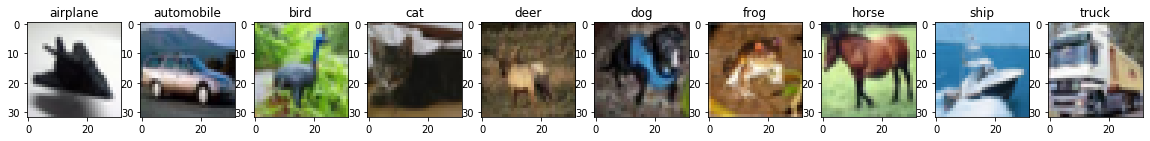

In [39]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord][0]])
plt.show()

In [55]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam
    #return cam
    #cv2.imwrite("cam.jpg", np.uint8(255 * cam))
    return cam

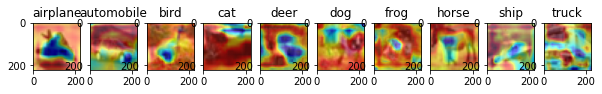

In [62]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    img= np.float32(cv2.resize(x_train[coord],(224,224)))/255
    input = preprocess_image(img)
    
    grad_cam = GradCam(model = models.vgg19(pretrained=True), \
					target_layer_names = ["35"], use_cuda="use-cuda")
    mask = grad_cam(input,target_index)
    cam=show_cam_on_image(img,mask)
    plt.imshow(cam)
    plt.title(label_list[y_train[coord][0]])
    
    #plt.imshow(x_train[coord])
    #plt.title(label_list[y_train[coord][0]])

plt.show()

# References 
https://github.com/jacobgil/pytorch-grad-cam/blob/master/grad-cam.py